<a href="https://colab.research.google.com/github/MANOJ-S-NEGI/Structured_Dataset/blob/main/insurance__dataset(Binary_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building and training neural network models using TensorFlow 2.x
You need to understand the foundational principles of machine learning (ML) and deep learning (DL)
>using TensorFlow 2.x. You need to know how to:
* ❏ Use TensorFlow 2.x.
* ❏ Build, compile and train machine learning (ML) models using TensorFlow.
* ❏ Preprocess data to get it ready for use in a model.
* ❏ Use models to predict results.
* ❏ Build sequential models with multiple layers
* ❏ Build and train models for binary classification.
* ❏ Build and train models for multi-class categorization.
* ❏ Plot loss and accuracy of a trained model.
* ❏ Identify strategies to prevent overfitting, including augmentation and dropout.
* ❏ Use pretrained models (transfer learning).
* ❏ Extract features from pre-trained models.
* ❏ Ensure that inputs to a model are in the correct shape.
* ❏ Ensure that you can match test data to the input shape of a neural network.
* ❏ Ensure you can match output data of a neural network to specified input shape for test data.
* ❏ Understand batch loading of data.
* ❏ Use callbacks to trigger the end of training cycles.
* ❏ Use datasets from different sources.
* ❏ Use datasets in different formats, including json and csv.
* ❏ Use datasets from tf.data.datasets.


In [32]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
                              ( MinMaxScaler(), ["age", "bmi", "children"]), # minmacscaler get/makes  all values between 0 and 1
                              (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
                             )
ct

ColumnTransformer(transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['age', 'bmi', 'children']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['sex', 'smoker', 'region'])])

In [39]:
from sklearn.model_selection import train_test_split
# Create x & y
x = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

In [44]:
# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(x_train)

# # Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
x_train_normal = ct.transform(x_train)
x_test_normal = ct.transform(x_test)

In [50]:
x_train_normal[1]

array([0.47826087, 0.67231172, 0.2       , 0.        , 1.        ,
       1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        ])

In [48]:
# Non-normalized and non-one-hot encoded data example
x_train.iloc[1]

age                40
sex              male
bmi             41.23
children            1
smoker             no
region      northeast
Name: 209, dtype: object

In [52]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
x_train_normal.shape, x_train.shape

((1070, 11), (1070, 6))

In [70]:
# Set random seed
tf.random.set_seed(21)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
history=insurance_model.fit(x_train_normal, y_train, epochs=500, verbose=0)

In [71]:
# Evaulate insurance model
insurance_model_loss, insurance_model_mae = insurance_model.evaluate(x_test_normal, y_test)

9/9 [==============================] - 0s 3ms/step - loss: 3623.1021 - mae: 3623.1021


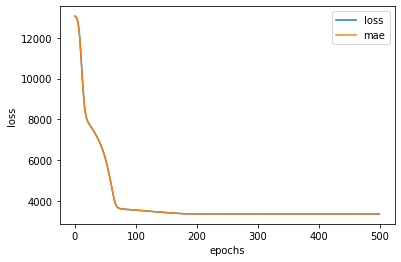

In [72]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable

In [88]:
ins_preds=insurance_model.predict(x_test_normal)

In [89]:
ins_preds[:10]

array([[ 5911.9985],
       [ 5919.2246],
       [10226.318 ],
       [37592.836 ],
       [ 8307.413 ],
       [10048.416 ],
       [42030.28  ],
       [ 9503.042 ],
       [40271.23  ],
       [42659.6   ]], dtype=float32)

In [74]:
# Save a model using the SavedModel format
insurance_model.save('best_model_SavedModel_format.h5')

In [76]:
# Load a model from the SavedModel format
loaded_saved_model = tf.keras.models.load_model("best_model_SavedModel_format.h5")
loaded_saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 100)               1200      
                                                                 
 dense_24 (Dense)            (None, 10)                1010      
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 2,221
Trainable params: 2,221
Non-trainable params: 0
_________________________________________________________________


In [96]:
# Compare model_2 with the loaded HDF5 version (should return True)
h5_model_preds = loaded_saved_model.predict(x_test_normal)

In [97]:
tf.keras.metrics.mean_absolute_error(y_test, h5_model_preds.squeeze()).numpy() == tf.keras.metrics.mean_absolute_error(y_test, ins_preds.squeeze()).numpy()

True

In [ ]:
# Download the model (or any file) from Google Colab
# from google.colab import files
# files.download("best_model_HDF5_format.h5")